This code uses the freud package, alongwith PyLammps, to calculate the structure factor for a single user-defined snapshot in a lammps trajectory file. 

In [1]:
import numpy as np
import time
from cycler import cycler
import matplotlib
from matplotlib import pyplot
from matplotlib.colors import colorConverter
myHexColors = ["#30A2DA", "#FC4F30", "#E5AE38", "#6D904F", "#9757DB", "#188487", "#FF7F00", "#9A2C66", "#626DDA", "#8B8B8B"]
myColorCycle = [colorConverter.to_rgb(i) for i in myHexColors]
from freud import parallel
parallel.setNumThreads(4)

from ipywidgets import IntProgress
from IPython.display import display

# matplotlib.rcParams.update({'font.sans-serif': 'Helvetica'})
# matplotlib.rcParams.update({'font.family': 'sans-serif'})
matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams.update({'axes.labelsize': 24})
matplotlib.rcParams.update({'xtick.labelsize': 18})
matplotlib.rcParams.update({'ytick.labelsize': 18})
matplotlib.rcParams.update({'savefig.pad_inches': 0.025})
matplotlib.rcParams.update({"axes.prop_cycle": cycler(color=myColorCycle)})
matplotlib.rcParams.update({"lines.linewidth": 2})

# lammps
from lammps import lammps, PyLammps
lmp = lammps()
L = PyLammps(ptr=lmp) # Get PyLammps

LAMMPS output is captured by PyLammps wrapper


All user-defined stuff is in the next cell. Update the name of your trajectory file accordingly. It should be inside the subfolder *traj*. If you specify a frame that is not present in the lammps trajectory file, PyLammps will throw an error.
TODO: Read these from an input file?

In [2]:
# User-defined stuff
system = 'fcc'
typeID = 1
frameNo = 500000 #500000
# dumpFreq = 5000 #1000 #5000
# Dumpfile name to read from inside the folder traj
dumpfile = 'traj/dump-' + system + '.lammpstrj'
# Define the no. of grid points in each dim: 2*g+1
grid = 25

The next cell calculates the static structure factor for a single snapshot in the lammps trajectory file. 

/home/sadanandam/miniconda3/lib/python3.6/site-packages/freud/kspace.py:144: ComplexWarning: Casting complex values to real discards the imaginary part
  np.float32)


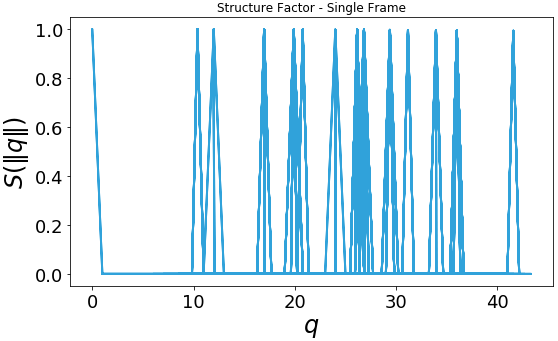

In [3]:
# import the freud object
# the rdf module is contained in the density module
from freud import box, kspace

# load the data
# Read in the lammps input file; uncomment if you run the cell more than once
lmp.file('lammpsFiles/inp.'+ system) # LAMMPS input file for the system
# Read in the trajectory file
L.read_dump(dumpfile, frameNo, "x y z box yes replace yes")

# Get the number of atoms of one typeID
natoms = 0
L.read_dump(dumpfile, frameNo, "x y z box yes replace yes")
for i in range(L.atoms.natoms):
    if L.atoms[i].type==typeID:
        natoms += 1
# Define numPy coordinate array; here natoms is the no. of atoms of type 1
x = np.zeros((natoms,3), dtype=float)

# Get the coordinates
for i in range(L.atoms.natoms):
    if L.atoms[i].type==typeID:
        for k in range(3):
            x[i][k] = L.atoms[i].position[k]

box_limits = [L.system.xhi-L.system.xlo, L.system.yhi-L.system.ylo, L.system.zhi-L.system.zlo] # box from lammps
# ---------- End of LAMMPS stuff

# compute the structure factor for one frame

# create the freud box object
fbox = box.Box(Lx=box_limits[0], Ly=box_limits[1], Lz=box_limits[2])

# create the structure factor object object
# g defines the no. of grid points = 2*g+1
strucFactor = kspace.SFactor3DPoints(box=fbox,g=grid) 

# compute 3-D static structure factor
strucFactor.compute(x)

# get the value of the histogram bins of the structure factor
S = strucFactor.getS()

# Create the object for the 1-D analog of the 3-D structure factor
stucOneD = kspace.AnalyzeSFactor3D(S)

# Get a list of all S(∣∣q∣∣) values vs q2.
sMod, q2 = stucOneD.getSvsQ()

# Take the square root of q2 to get q
q = np.sqrt(q2)

pyplot.figure(figsize=(8, 5))
pyplot.title("Structure Factor - Single Frame")
pyplot.plot(q, sMod)
pyplot.xlabel(r"$q$")
pyplot.ylabel(r"$S\left( \Vert q \Vert \right)$")
pyplot.tight_layout()
pyplot.show()
